# 6.임베딩 내 편향성 알아보기

## 6-1. 들어가며

### 인공지능은 객관적일까?

우리가 가진 데이터가 이미 편향되어 있다면 이를 이용하여 만든 알고리즘 또한 편향될 확률이 매우 높습니다. 그래서 최근에는 인공지능이 가진 편향성을 예방하기 위한 연구가 지속되고 있습니다. 특히 자연어처리 분야, 그중에서도 워드 임베딩과 관련된 연구가 많이 이루어지고 있습니다.

왜 그럴까요? 몇 가지 이유를 생각해 볼 수 있는데요. 우선 언어의 사용패턴이 담긴 코퍼스야말로 인간 무의식 속에 감추어진 편향성이 고스란히 드러나는 데이터셋이기 때문입니다.다른 이유로는 그 언어의 의미가 워드 임베딩에 추상적인 형태로 담겨 있는데, 최근 연구를 통해 그 임베딩 공간에서 편향성을 정량적으로 측정하는 방법론들이 발표되면서 이 분야의 연구가 활기를 띠게 되었기 때문입니다.

그래서 오늘은 워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론인 Word Embedding Association Test (WEAT)라는 기법에 대해 알아보고, 이를 활용해 우리가 학습시킨 Word2Vec 임베딩 내의 편향성을 측정해 보면서 실제로 이 방법론이 우리 머리 속에 있는 편향성을 잘 반영하는지도 살펴보겠습니다.

### 학습 목표
- 데이터의 편향성에 대한 문제의식을 갖는다.
- 임베딩 모델의 편향성을 체크하는 방법 중 하나인 Word Embedding Association Test (WEAT)를 알아본다.
- WEAT 수식의 의미를 이해하고 이를 구현해본다.
- pre-train된 모델을 불러와서 WEAT score를 구해본다.

### 목차
1. 워드 임베딩의 편향성
2. WEAT를 통한 편향성 측정
3. WEAT 구현하기
4. 사전학습된 Word Embedding에 WEAT 적용
5. 직접 만드는 Word Embedding에 WEAT 적용(1)
6. 직접 만드는 Word Embedding에 WEAT 적용(2)
7. 프로젝트 : 모든 장르 간 편향성 측정해 보기

## 6-2. 워드 임베딩의 편향성

### 워드 임베딩 속의 편향성
['Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings'](https://arxiv.org/pdf/1607.06520.pdf)

이 논문의 저자는 학습된 Word Embedding을 2차원으로 차원 축소해서 시각화했을 때, 분명히 젠더 중립적인 단어임에도 불구하고 Programmer, Doctor, Engineer 등의 단어는 남성대명사 He에 가깝게, Homemaker, Nurse, Hairdresser 등의 단어는 여성대명사 She에 가깝게 위치하는 것을 보여 줌으로써 큰 반향을 불러일으켰습니다. 우리가 가지고 있을지도 모를 편견이 워드 임베딩 속 벡터들에 고스란히 반영되어 있었다는 것을 보여 주었기 때문입니다.

### WEAT(Word Embedding Association Test)
Word Embedding Association Test (WEAT)는 임베딩 모델의 편향을 측정하는 방식 중 하나로, 2016년에 Aylin Caliskan이 제안했습니다.

- [논문 원본 : Semantics derived automatically from language corpora necessarily contain human biases](https://arxiv.org/pdf/1608.07187.pdf)

만약 Science와 Art가 모두 완벽히 젠더 중립적이라면, Word Embedding 상에서도 Science, Art가 Male, Female의 두 단어와의 거리가 동일해야 할 것입니다. 그러나 만약 정말 편향이 존재한다면, Science와 Male 간의 거리가 Science와 Female 간의 거리보다 가깝고, 거꾸로 Art와 Male 간의 거리는 Art와 Female간의 거리보다 멀어야겠죠?

우리는 워드 임베딩 간의 거리를 코사인 유사도로 계산할 수 있다는 것을 이미 알고 있으니, 그런 방식으로 계산해 보면 편향성을 쉽게 구할 수 있을 것 같습니다! 아주 간단한 아이디어죠?

WEAT는 Male과 Female, Science와 Art라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋(set)을 만듭니다. 단어 셋에 속한 모든 단어들끼리의 편향성을 전부 계산해서 평균을 수치화해보면 보다 명확하게 개념적인 편향성이 존재함을 밝힐 수 있지 않을까요?

이러한 단어 셋을 WEAT에서는 각각 __target__과 __attribute__라고 합니다.

위의 예를 다시 들자면, Science를 대표하는 target 단어 셋 X와 Art를 대표하는 target 단어 셋 Y가 있다고 하면 X-Y 셋을 통한 개념축 하나가 얻어집니다. Male을 대표하는 attribute 단어 셋 A와 Female을 대표하는 attribute 단어 셋 B가 있다면 A-B 셋을 통한 개념축 하나가 또 얻어집니다. 편향성이 없다면, X에 속한 단어들은 A에 속한 단어들과의 거리와 B에 속한 단어들과의 거리가 별 차이가 없어야 합니다. 반대의 경우라면 뚜렷하게 차이가 나겠죠. Y의 경우도 마찬가지입니다.

다음 스텝에 수식을 통해 보다 명확하게 설명할 WEAT score는 바로 위와 같은 방식으로 계산된 수치입니다. 절댓값이 클수록 두 개념축 사이의 편향성이 크게 나타나는 것으로 해석됩니다.

(참고)
WEAT 개념의 아이디어는 심리학의 __IAT(Implicit Association Test)__ 라는 인지편향성 실험 구조에서 따온 것입니다. IAT는 WEAT처럼 X-Y, A-B 두 개념축을 설정하는 점에서는 동일합니다. 다만 단어들 사이의 거리를 측정하는 방법이 워드 임베딩간 코사인 유사도를 계산하는 방식이 아니라, 피실험자들에게 전자적으로 단어 연상 실험을 하면서 응답 반응 속도를 측정하는 방식을 사용했을 뿐입니다. 매우 재미있는 아이디어이므로 심리학에 관심이 있으시다면 아래 링크를 열어서 IAT 테스트를 수행하여 본인 무의식 속에 있는 편향성을 측정해 보세요.
- [IAT 홈페이지 : Project Implicit](https://implicit.harvard.edu/implicit/education.html)

아래 표는 구글의 테크블로그에서 WEAT 개념을 소개하면서 첨부한 실험 결과표입니다.

- [Text Embedding Models Contain Bias. Here's Why That Matters](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)

표에서 파란색은 사람의 편향과 같은 경우이고, 노란색은 사람의 편향과 반대인 경우를 의미합니다. (사람이 가진 편향은 Implicit Association Tests로 측정했습니다.)

표를 보면 대부분의 색이 파란색인 것을 볼 수 있습니다. 이 표가 또한 말해주는 것은 사람이 가진 편향이 자연어 코퍼스 데이터에 반영되어 있고, 이 데이터로 만든 워드 임베딩 모델은 그 편향을 내재할 수밖에 없다는 점입니다.

꽃과 벌레, 유쾌함과 불쾌함 등 누구나 동의할만한 편향성이 존재하는 경우엔 대부분의 경우 WEAT score의 절댓값이 1.5 이상으로 뚜렷한 편향성 수치가 나오는 것을 볼 수 있습니다. 그 외에도 다양한 개념축간 편향성이 존재하는 것을 흥미롭게 살펴볼 수 있습니다.

Glove, Word2Vec 등 다양한 워드 임베딩 모델에 대해 동일한 실험을 하여 WEAT score를 측정해 본 결과도 흥미롭습니다. 모델마다 WEAT score가 동일하게 나오는 것이 아닙니다. 이런 차이점의 원인을 분석해 보는 것도 흥미로울 것 같습니다.

## 6-3. WEAT를 통한 편향성 측정

WEAT score는 다음과 같이 정의합니다.

$$ \frac{mean_{x \in X^S}(x,A,B)-mean_{y \in Y^S}(y,A,B)}{std_{w \in X \cup Y^S}(w,A,B)}$$

이 테스트는 두 벡터의 유사도를 측정하기 위해 cosine similarity를 이용합니다. cosine similarity는 두 벡터 사이의 cosine 값을 이용하여 두 벡터의 유사도를 측정합니다. 다시 말해, 두 벡터 $i,J$가 주어졌을 때, cosine similarity $cos(\theta)$는 dot product와 magnitude를 사용하여 구할 수 있습니다.
$$cos(\theta)=\frac{i*j}{\left\|i\right\|\left\|j\right\|}$$
- $cos(\theta)=1$: 두 벡터의 방향이 똑같을 때
- $cos(\theta)=0$: 두 벡터가 직교할 때
- $cos(\theta)=-1$: 두 벡터의 방향이 반대일 때

cosine similarity는 -1에서 1을 가질 수 있으며 두 벡터의 방향이 얼마나 유사한지를 나타내게 됩니다.

벡터 $\overrightarrow{i}$와 $\overrightarrow{j}$가 있을 때, $cos(\overrightarrow{i},\overrightarrow{j})$는 벡터 $\overrightarrow{i}$와 $\overrightarrow{j}$의 cosine similarity를 의미하므로, 아래 식의 $s(w, A, B)$가 의미하는 것은 target에 있는 단어 $w$가 두 attribute 셋 A, B에 속한 단어들과의 유사도의 평균(mean)값이 얼마나 차이 나는지를 측정합니다. 즉, $s(w, A, B)$는 개별 단어 $w$가 개념축 A-B에 대해 가지는 편향성을 계산한 값이 됩니다. 이 편향성 값은 -2에서 2사이의 값을 가지게 되며, 그 절댓값이 클수록 w는 A-B 개념축에 대해 편향성을 가진다는 뜻이 됩니다.

$$ s(w, A, B)=mean_{a \in A}cos(\overrightarrow{w},\overrightarrow{a})-mean_{b \in B}cos(\overrightarrow{w},\overrightarrow{b})$$

이제 맨 위에 소개했던 WEAT score의 정의로 되돌아가 봅시다.

위 식의 분자 부분은 target X, Y에 속하는 각 단어 $x$, $y$들이 개념축 A-B에 대해 가지는 편향성을 r각각 평균 내서 뺀 차이입니다. 즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절댓값은 커지게 됩니다. 이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 됩니다.

설명이 좀 복잡했지만 다음 스텝에서 구현 예시를 통해 좀 더 명확히 이해해 봅시다.

## 6-4. WEAT 구현하기

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

print("슝~")

슝~


우선 두 개의 target 단어 셋 X, Y와 두 개의 attribute 단어 셋 A, B를 정의합니다.
단어 셋을 정할 때는 두 개의 target 셋의 크기가 같아야 하고, 두 개의 attribute 셋의 크기가 같아야 합니다.

- targets
    - X set(꽃) : 장미, 튤립, 백합, 데이지
    - Y set(곤충) : 거미, 모기, 파리, 메뚜기

- attributes
    - A set(유쾌) : 사랑, 행복, 웃음
    - B set(불쾌) : 재난, 고통, 증오

위 단어들의 임베딩 결과가 다음과 같다고 해봅시다.

In [2]:
target_X = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_Y = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_A = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_B = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

print("슝~")

슝~


In [3]:
X = np.array([v for v in target_X.values()])
Y = np.array([v for v in target_Y.values()])
print(X)
print(Y)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [4]:
A = np.array([v for v in attribute_A.values()])
B = np.array([v for v in attribute_B.values()])
print(A)
print(B)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


`s('장미', A, B)` 를 계산해보도록 하겠습니다.

In [5]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(target_X['장미'], A, B))

0.6457646122337399


WEAT score값이 양수이므로, target_X에 있는 '장미'라는 단어는 attribute_B(불쾌)보다 attribute_A(유쾌)와 더 가깝다는 것을 알 수 있습니다. target_Y에 있는 '거미'와 attribute_A, attribute_B와의 관계도 계산해봅시다.



In [6]:
print(s(target_Y['거미'], A, B))

-0.794002342033094


위와 반대로 WEAT score가 음수가 나왔으므로, '거미'는 attribute_B와 더 가깝다는 것을 알 수 있습니다.

그럼 target_X와 attribute_A, attribute_B 사이의 평균값, 그리고 target_Y와 attribute_A, attribute_B 사의의 평균값은 어떻게 될까요?

In [7]:
print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3))

[0.29551989 0.51723181 0.26499096 0.50924109]
0.397


target_X와 attribute_A, attribute_B 사이의 평균값은 0.397입니다.

In [8]:
print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[-0.44713039 -0.28310853 -0.33144878 -0.26030641]
-0.33


target_Y와 attribute_A, attribute_B 사이의 평균값은 -0.33입니다.

그럼 이번에는 WEAT score의 수식 전체를 코드로 나타내 봅시다.

$$ \frac{mean_{x \in X^S}(x,A,B)-mean_{y \in Y^S}(y,A,B)}{std_{w \in X \cup Y^S}(w,A,B)}$$

In [9]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

print(round(weat_score(X, Y, A, B), 3))

1.932


WEAT score가 매우 높게 나온 것을 알 수 있습니다. 즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다는 것을 수치적으로 확인할 수 있었습니다.

이제 이를 시각적으로 확인해볼까요? PCA를 통해 5차원이었던 벡터를 2차원으로 줄여 그림을 그려보겠습니다.

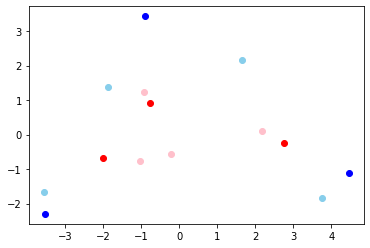

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현된 것을 확인할 수 있습니다.

## 6-5. 사전학습된 Word Embedding에 WEAT 적용

지금까지 WEAT가 어떻게 계산되는지 확인해보았습니다. 이제 실제 pretrain된 임베딩 모델을 이용하여 계산해볼까요?

구글에서 학습한 모델을 사용해보도록 하겠습니다.

우선 ~/aiffel/weat 폴더를 만들고 링크를 걸어 줍니다. 압축을 풀면 대략 3G 정도 됩니다. (아래 링크에서 다운받아 로컬에서도 확인해볼수 있습니다.)

[GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download)

```$ mkdir -p ~/aiffel/weat
$ ln -s ~/data/* ~/aiffel/weat/
$ cd ~/aiffel/weat
$ ls -l```

gensim 설치 후 다음 코드에서 data_dir 변수에 본인의 경로를 잘 설정해서 모델을 불러오도록 합니다.( 클라우드 사용자는 이미 설치가 되어있습니다.)

`$ pip install gensim`

> 💡 참고<br>
w2v를 사용하다가 메모리 부족이 발생할 수 있습니다. 이때는 워드 임베딩 내 300만 개의 단어 중 자주 쓰는 단어 50만 개만 꺼내어 사용하도록 아래와 같이 limit 파라미터값을 주면 메모리 사용량을 크게 줄일 수 있습니다.

`w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)`

In [30]:
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

In [12]:
w2v

w2v에 있는 단어 개수와 벡터 크기를 살펴볼까요?

> 💡 참고<br>
2021년 3월, Gensim이 4.0 으로 버전업되면서 KeyedVectors에 vocab dict가 제거되었습니다. 상세한 내용은 아래 링크를 참고해 주세요.

- [Migrating from Gensim 3.x to 4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)

In [19]:
# print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


w2v에는 limit으로 지정한 갯수(디폴트는 3,000,000개)의 단어가 있고, 각 단어는 300차원을 갖는다는 것을 알 수 있습니다.

'happy'라는 단어의 벡터를 살펴보겠습니다.

In [20]:
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

'happy'와 가장 유사한 단어를 보도록 하겠습니다.

In [21]:
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.627237856388092),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665286064148)]

다른 단어들도 살펴보도록 하겠습니다.

In [22]:
w2v.most_similar(positive=['family'])

[('relatives', 0.6662653088569641),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894997596741),
 ('siblings', 0.6140849590301514),
 ('friends', 0.6128394603729248),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319947242737),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

오타로 추정되는 몇몇 단어도 보입니다. 이 단어들도 데이터 자체에 자주 나왔기 때문에 단어 셋에 포함되었다고 생각할 수 있습니다.

In [23]:
w2v.most_similar(positive=['school'])

[('elementary', 0.7868632078170776),
 ('schools', 0.7411909103393555),
 ('elementary_schools', 0.6597153544425964),
 ('kindergarten', 0.6529811024665833),
 ('eighth_grade', 0.6488089561462402),
 ('School', 0.6477997303009033),
 ('teacher', 0.63824063539505),
 ('students', 0.6301522850990295),
 ('classroom', 0.6281620264053345),
 ('Schools', 0.6172096133232117)]

어떤가요? 이 모델이 단어의 의미를 담은 벡터로 변환이 잘 되었다고 생각하나요?

이제 WEAT를 통해 이 모델의 편향성을 확인해보도록 하겠습니다. 논문에 있던 단어 셋으로 구성해보겠습니다.

In [24]:
target_X = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_Y = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.2624874

과학과 관련된 단어가 남성과 관련된 단어와 가깝고, 예술과 관련된 단어가 여성과 관련된 단어와 가깝게 나타났습니다. 사람의 편향성을 실험하는 IAT에서도 이와 같게 나타났었죠? 많은 사람이 가진 편향이 임베딩 모델에 반영되었다고 볼 수 있습니다.

이제 다른 셋을 구성해볼까요? target_X는 인스턴트 식품들로 단어를 구성하였고 target_Y는 그 반대로 구성했습니다. attribute_A는 인스턴트를 의미하는 단어들로, attributes_B는 그 반대로 구성했습니다.

이 단어 셋들을 보면 target_X는 attribute_A와 attribute_B 중 어떤 것과 가깝다고 생각하시나요?
보통 target_X와 attribute_A가 가깝고, traget_Y는 attribute_B와 가깝다고 대답할 것입니다.
임베딩 모델도 그렇게 생각할까요?

In [25]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_B = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

1.6909266

모델도 우리의 예상과 맞는 방향으로 상당히 높은 수치를 보이는 것을 확인했습니다. 인스턴트 식품의 예시와 인스턴트를 의미하는 단어가 가까운 것은 당연합니다. 이 경우 모델이 편향되어있다기보다 단어의 의미를 잘 파악했다고 볼 수 있습니다.

동일한 target 셋에 다른 attribute 셋을 만들볼까요? attribute_A에는 책과 관련된 단어로 구성하고, attribute_B는 뉴스와 관련된 단어로 구성했습니다. 이번에는 어떤 결과를 가져올까요?

In [27]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_B = ['news', 'report', 'statement', 'broadcast', 'word']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

-0.05137869

0에 굉장히 가까운 결과를 보였습니다. 즉, 임베딩 모델이 판단하기에 어느 것끼리 가깝다고 말할 수 없는 것이지요.

여러분이 target, attribute 셋을 만들어서 WEAT score를 구해보세요.

In [31]:
target_X = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_Y = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_A = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_B = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

X = np.array([w2v[word] for word in target_X])
Y = np.array([w2v[word] for word in target_Y])
A = np.array([w2v[word] for word in attribute_A])
B = np.array([w2v[word] for word in attribute_B])

weat_score(X, Y, A, B)

0.33343452

In [32]:
#메모리를 다시 비워줍시다.
del w2v
print("삭제 완료")

삭제 완료
